# ML Binary Classification


## Setup


In [1]:
import datasets
import nltk
from nltk import sent_tokenize
import torch
import seaborn as sns
import transformers
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments,
)
import matplotlib.pyplot as plt
import numpy as np
import evaluate

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/016854656/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
ds = datasets.load_dataset("sem_eval_2020_task_11", data_dir="./datasets")
ds

DatasetDict({
    train: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 371
    })
    test: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 90
    })
    validation: Dataset({
        features: ['article_id', 'text', 'span_identification', 'technique_classification'],
        num_rows: 75
    })
})

In [3]:
def preprocess(ds: dict):
    items = []
    for entry in ds:
        text: str = entry["text"]
        spans = list(
            zip(
                entry["technique_classification"]["start_char_offset"],
                entry["technique_classification"]["end_char_offset"],
            )
        )
        newline_split = text.split("\n")

        for line in newline_split:
            # figure out where the line is
            tokenized_line = sent_tokenize(line)
            for tokenized_sentence in tokenized_line:
                assert type(tokenized_sentence) == str
                index = text.index(tokenized_sentence)

                is_classified = False
                for i in range(len(tokenized_sentence)):
                    for span in spans:
                        if span[0] <= index + i <= span[1]:
                            # mark it as true
                            is_classified = True
                            break

                items.append((tokenized_sentence, is_classified))
    return items


train_preprocessed = preprocess(ds["train"])
validation_preprocessed = preprocess(ds["validation"])
test_preprocessed = preprocess(ds["test"])

In [4]:
ds["test"][0]

{'article_id': 'article813452859',
 'text': "EU Profits From Trading With UK While London Loses Money – Political Campaigner\n\nWith the Parliamentary vote on British Prime Minister Theresa May’s Brexit plan set to be held next month; President of the European Commission Jean Claude Juncker has criticised the UK’s preparations for their departure from the EU.\nBut is there any chance that May's deal will make it through parliament and if it fails, how could this ongoing political deadlock finally come to an end?\nSputnik spoke with political campaigner Michael Swadling for more…\nSputnik: Does Theresa May have any chance of getting her deal through Parliament on the 14th January?\nMichael Swadling: I guess her only chance is if Labour decides that they want to dishonour democracy and effectively keep us in the EU.\n© AP Photo / Pablo Martinez Monsivais UK 'In Need of Leadership', May's Brexit Deal Unwelcome to Trump - US Ambassador\nThere is a chance; as unfortunately there are many MP

## Dataset Configuration


In [5]:
MIN_LENGTH = 10  # minimum number of characters per sentence


def cap(ds: list):
    temp = []
    for entry in ds:
        if len(entry[0]) >= MIN_LENGTH:
            temp.append(entry)
    return temp


train_preprocessed = cap(train_preprocessed)
validation_preprocessed = cap(validation_preprocessed)
test_preprocessed = cap(test_preprocessed)

Trues: 0.2900946294703208, Falses: 0.7099053705296793


([<matplotlib.patches.Wedge at 0x7f8eed9b99d0>,
 [Text(0.6739392966959616, 0.8693709360042771, 'True'),
  Text(-0.6739392152995776, -0.8693709991030238, 'False')])

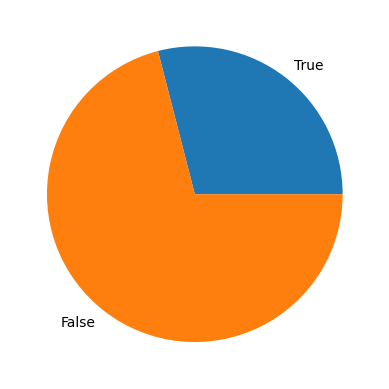

In [6]:
def make_plots(ds: list):
    labels = [label for _, label in ds]
    trues, falses = labels.count(True), labels.count(False)
    print(f"Trues: {trues/len(labels)}, Falses: {falses/len(labels)}")
    return plt.pie([trues, falses], labels=["True", "False"])


make_plots(train_preprocessed)

Trues: 0.2544744549300358, Falses: 0.7455255450699642


([<matplotlib.patches.Wedge at 0x7f8eeb819ed0>,
 [Text(0.7668072445634918, 0.7886739818739715, 'True'),
  Text(-0.7668072445634918, -0.7886739818739713, 'False')])

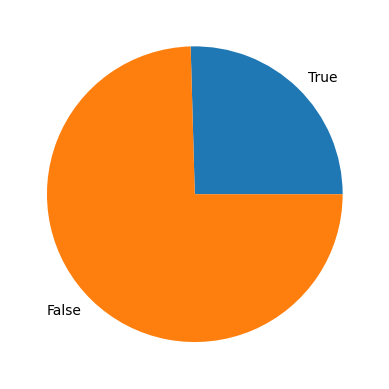

In [7]:
make_plots(validation_preprocessed)

Trues: 0.3550540368722187, Falses: 0.6449459631277813


([<matplotlib.patches.Wedge at 0x7f8eedbfce10>,
 [Text(0.48376534110686337, 0.9879124934647605, 'True'),
  Text(-0.4837652486118186, -0.9879125387581359, 'False')])

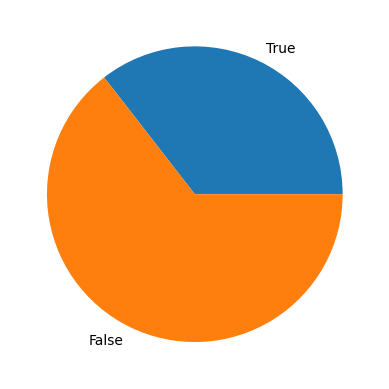

In [8]:
make_plots(test_preprocessed)

## Setup Model Workflow


In [9]:
model_name = "bert-large-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Format Dataset


In [10]:
train = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in train_preprocessed],
        "labels": [1 if label else 0 for _, label in train_preprocessed],
    }
)
validation = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in validation_preprocessed],
        "labels": [1 if label else 0 for _, label in validation_preprocessed],
    }
)
test = datasets.Dataset.from_dict(
    {
        "text": [sentence for sentence, _ in test_preprocessed],
        "labels": [1 if label else 0 for _, label in test_preprocessed],
    }
)

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


train = train.map(preprocess_function)
validation = validation.map(preprocess_function)
test = test.map(preprocess_function)

Map:   0%|          | 0/16274 [00:00<?, ? examples/s]

Map:   0%|          | 0/3073 [00:00<?, ? examples/s]

Map:   0%|          | 0/3146 [00:00<?, ? examples/s]

## Training Args and Training


In [12]:
collator = DataCollatorWithPadding(tokenizer)

In [13]:
metrics = evaluate.combine(["accuracy", "recall", "precision", "f1"])
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return metrics.compute(predictions=predictions, references=labels)

In [14]:
args = TrainingArguments(
    run_name="metrics_large",
    num_train_epochs=1,
    output_dir="./runs",
    per_device_train_batch_size=12,
    weight_decay=0.1,
    learning_rate=7e-5,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=100,
)

In [15]:
trainer = Trainer(
    model,
    args=args,
    data_collator=collator,
    train_dataset=train,
    eval_dataset=validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
# trainer.train()